In [4]:
import csv
import cv2
import torch
import numpy as np
from PIL import Image
import torch.nn as nn
from sklearn import metrics
from torch.utils.data import Dataset
from torchvision import transforms, models

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [14]:
import pandas as pd

In [19]:
class FrameDataset(Dataset):
    def __init__(self, data, transform=None, label=None):
        """
        Args:
        data(numpy image)
        transform: Pytorch transforms for transformations and tensor conversion
        """
        self.data = data
        self.transform = transform
        self.label = label

    def __getitem__(self, index):
        """
        :param index: Index of the image
        :return: Transformed image
        """
        image = Image.fromarray(self.data)
        if self.transform is not None:
            image = self.transform(image)
        return image

    def __len__(self):
        return 1


class VideoFrameClassifier():
    def __init__(self, model_path):
        self.checkpoint = torch.load(model_path, map_location=lambda storage, loc: storage)
        self.model = models.resnet34()
        self.model.fc = nn.Linear(512, 4)
        self.model.load_state_dict(self.checkpoint.get('state_dict'))
        self.model.eval()
        self.dataTransform = None
        self.frame_type_mapper = {
            '0': 'codewalk',
            '1': 'handwritten',
            '2': 'misc',
            '3': 'slides'
        }

    def transform_input(self, current_image):
        """Applies and transforms the given image to format for model
            @parameter
               current_contrast level (int/float)
                    current contrast level to be applied on image
                current_image:
                    Current image data
            @returns
                Transformed image to be feed into model
        """
        input_image = Image.fromarray(current_image)
        input_image = input_image.convert('RGB')
        input_image = input_image.resize(self.input_size, Image.ANTIALIAS)
        input_image = transforms.ToTensor()(input_image)
        width, height = input_image.size(1), input_image.size(2)
        input_image = input_image[0, :, :].view(1, width, height)
        input_image = input_image.unsqueeze(0)
        print(input_image.size())
        return input_image

    def get_prediction(self, image_data):
        """Get prediction of input image
            @parameter
               Image_data (numpy array)
                    current image for which prediction is needed
            @returns
                @type(numpy.int64)
                Class of current frame type
        """
        self.image = image_data
        self.model.eval()
        self.model = self.model.cpu()
        self.input_size = (400, 400)
        self.dataTransform = transforms.Compose([
            transforms.Resize(self.input_size),
            transforms.ToTensor()
        ])
        self.transformedDataset = FrameDataset(data=image_data, transform=self.dataTransform)
        self.dataloader = torch.utils.data.DataLoader(
            self.transformedDataset,
            batch_size=1,
            shuffle=False
        )
        with torch.no_grad():
            for input_image in self.dataloader:
                prediction = self.model(input_image)
                prediction = np.argmax(prediction.detach().numpy())
        return prediction

    def classify_frame(self, image_data, ground_truth=None) -> str:
        """Classify the frame type(codewalk/misc/handwritten/others).
            @parameter
               image_data (numpy nd array)
                    Input Image
            @returns
                Type of frame - str
        """

        frame_type = self.get_prediction(image_data)
        frame_type = self.frame_type_mapper.get(str(frame_type))
        return frame_type


# Validate output with groundtruth

In [20]:
mapper_dict = { 'codewalk' : 0,
                'handwritten':1,
                'misc':2,
                'slides':3
                }
frame_type_mapper = {
    '0': 'codewalk',
    '1': 'handwritten',
    '2': 'misc',
    '3': 'slides'
}
model_path = 'models/checkpoint_best_400.pth'
frame_classifier = VideoFrameClassifier(model_path)
test_set_path ='dataset_csv/test_set.csv'
with open(test_set_path,'r') as csv_file:
    reader = csv.reader(csv_file)
    data = list(reader)
prediction_list =[]
groundtruth_list = []
for each_file in data:
    file_path = each_file[0]
    groundtruth = each_file[1]
    image = cv2.imread(file_path)
    frame_type = frame_classifier.classify_frame(image, ground_truth=None)
    prediction_list.append(frame_type)
    groundtruth_list.append(frame_type_mapper[str(groundtruth)])

data = metrics.confusion_matrix(groundtruth_list, prediction_list)
# Print the confusion matrix
print(metrics.confusion_matrix(groundtruth_list, prediction_list))
# Print the precision and recall, among other metrics
print(metrics.classification_report(groundtruth_list, prediction_list, digits=3))

[[ 96   2   3   4]
 [  2 140  14   2]
 [  1   1 105   6]
 [  0   0  13 128]]
              precision    recall  f1-score   support

    codewalk      0.970     0.914     0.941       105
 handwritten      0.979     0.886     0.930       158
        misc      0.778     0.929     0.847       113
      slides      0.914     0.908     0.911       141

    accuracy                          0.907       517
   macro avg      0.910     0.909     0.907       517
weighted avg      0.915     0.907     0.909       517



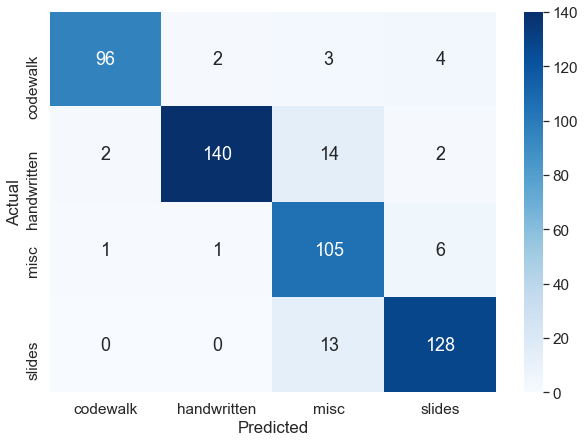

In [22]:
df_cm = pd.DataFrame(data, columns=np.unique(groundtruth_list), index = np.unique(prediction_list))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 18},fmt='g')# font size

In [21]:
metrics.multilabel_confusion_matrix(groundtruth_list,prediction_list)

array([[[409,   3],
        [  9,  96]],

       [[356,   3],
        [ 18, 140]],

       [[374,  30],
        [  8, 105]],

       [[364,  12],
        [ 13, 128]]], dtype=int64)